In [1]:
%%time
# !head -n 20 bluetooth_graph_analysis.py
!awk 'FNR>=28 && FNR<=50' bluetooth_graph_analysis.py
%run bluetooth_graph_analysis.py
%matplotlib inline

from speclib import misc, plotting, loaders, graph  # noqa
PRINT = False
PRINT_PROGRESS = True


@jit()
def compareDfUsers(baseuser, peers, df):
    # Compute the similarity in the way they answered the questions
    dct = dict()
    for i in range(len(peers)):
        dct[(baseuser, peers[i])] = simfnc(df.loc[baseuser], df.loc[peers[i]])
    sim = pd.Series(dct).sort_values(ascending=False)
    return sim


dfa  = pd.read_msgpack('/lscr_paper/allan/allan_data/participants_graph_adjacency.msgpack')
mask = dfa.sum() != 0
dfa  = dfa.loc[mask, mask]  # drop zero-columns
dfa.head()
qdf  = pd.read_json('/lscr_paper/allan/allan_data/RGender_.json')
q    = misc.QuestionCompleter(qdf)
f    = misc.QuestionFilterer(qdf)
ua   = loaders.Useralias()


/lscr_paper/allan/scripts/morequestions/bluetooth_graph_analysis.py:74: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  qdf = qdf[alcohol_questions.notnull().any(axis=1)]


Processing user u0001 (0/842)


/lscr_paper/allan/scripts/speclib/graph.py:562: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(ua, ub)/(np.sqrt(ua**2).sum() * np.sqrt(ub**2).sum())


Processing user u0048 (40/842)
Processing user u0094 (80/842)
Processing user u0141 (120/842)
Processing user u0197 (160/842)
Processing user u0249 (200/842)
Processing user u0306 (240/842)
Processing user u0361 (280/842)
Processing user u0413 (320/842)
Processing user u0465 (360/842)
Processing user u0518 (400/842)
Processing user u0569 (440/842)
Processing user u0618 (480/842)
Processing user u0664 (520/842)
Processing user u0711 (560/842)
Processing user u0760 (600/842)
Processing user u0809 (640/842)
Processing user u0860 (680/842)
Processing user u0902 (720/842)
Processing user u0949 (760/842)
Processing user u1004 (800/842)
Processing user u1057 (840/842)
CPU times: user 4min 27s, sys: 1.63 s, total: 4min 28s
Wall time: 4min 27s


In [2]:
df_alcohol = pd.concat(alcohol) 
df_big5 = pd.concat(big5)
df_people = pd.concat(people)

Text(0.5,1,'people_control')

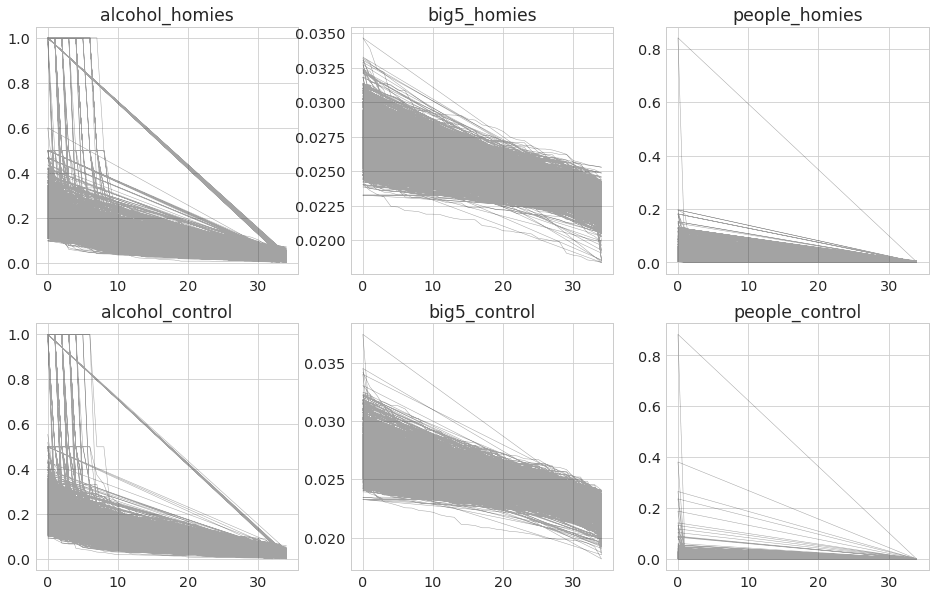

In [4]:
fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2, 3, figsize=(16, 10))
df_alcohol.alcohol_homies.plot(ax=ax11, alpha=0.4, lw=0.5, color='k')
ax11.set_title('alcohol_homies')
df_big5.big5_homies.plot(ax=ax12, alpha=0.4, lw=0.5, color='k')
ax12.set_title('big5_homies')
df_people.people_homies.plot(ax=ax13, alpha=0.4, lw=0.5, color='k')
ax13.set_title('people_homies')

df_alcohol.alcohol_control.plot(ax=ax21, alpha=0.4, lw=0.5, color='k')
ax21.set_title('alcohol_control')
df_big5.big5_control.plot(ax=ax22, alpha=0.4, lw=0.5, color='k')
ax22.set_title('big5_control')
df_people.people_control.plot(ax=ax23, alpha=0.4, lw=0.5, color='k')
ax23.set_title('people_control')


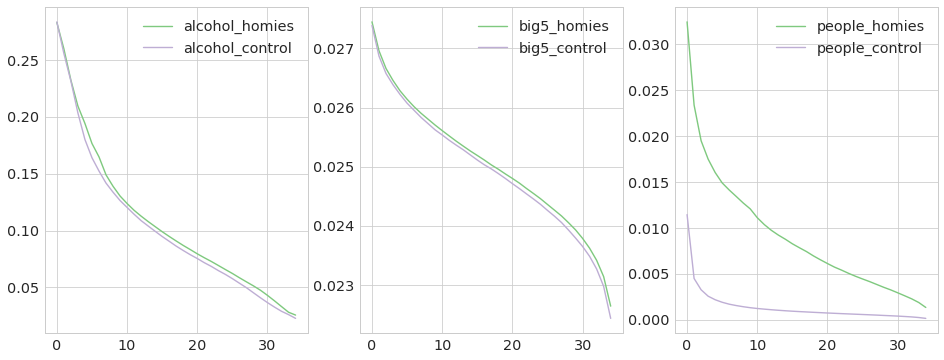

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))
df_alcohol.groupby(df_alcohol.index).mean().plot(ax=ax1)
df_big5.groupby(df_alcohol.index).mean().plot(ax=ax2)
df_people.groupby(df_alcohol.index).mean().plot(ax=ax3)

alcohol_homies           alcohol_control           big5_homies            \
            mean       std            mean       std        mean       std   
0       0.272731  0.220762        0.273303  0.219429    0.027418  0.001952   
1       0.250430  0.214870        0.246509  0.207464    0.026929  0.001796   
2       0.223829  0.185325        0.223111  0.185711    0.026630  0.001682   
3       0.201898  0.161526        0.196013  0.147352    0.026427  0.001612   
4       0.187164  0.150859        0.173558  0.109412    0.026252  0.001564   

  big5_control           people_homies           people_control            
          mean       std          mean       std           mean       std  
0     0.027358  0.001987      0.032460  0.039602       0.011451  0.037277  
1     0.026839  0.001749      0.023387  0.018966       0.004491  0.003166  
2     0.026545  0.001657      0.019502  0.014819       0.003260  0.001914  
3     0.026355  0.001613      0.017501  0.013629       0.002562  0.001188  
4     0.026190  0.001559      0.016042  0.012475       0.002176  0.000922

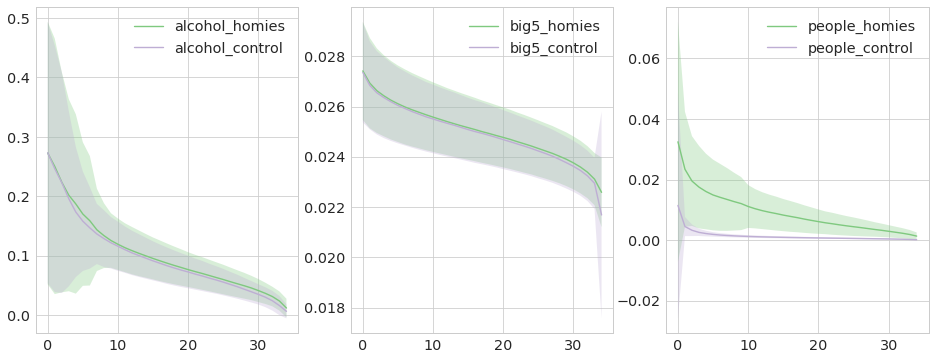

In [21]:
df_alcohol  = df_alcohol.fillna(0)
df_big5     = df_big5.fillna(0)
df_people   = df_people.fillna(0)
dfm_alcohol = df_alcohol.groupby(df_alcohol.index).agg(['mean', 'std'])
dfm_big5    = df_big5.groupby(df_big5.index).agg(['mean', 'std'])
dfm_people  = df_people.groupby(df_people.index).agg(['mean', 'std'])
display(dfm_alcohol.head().join([dfm_big5.head(), dfm_people.head()]))

def plotit(df, ax, lbl):
    df[lbl].plot(y='mean', ax=ax, label=lbl)
    yerr_upper_bound = df[lbl]['mean'] + df[lbl]['std']
    yerr_lower_bound = df[lbl]['mean'] - df[lbl]['std']
    ax.fill_between(df.index, yerr_lower_bound, yerr_upper_bound, alpha=0.3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))
plotit(dfm_alcohol, ax1, 'alcohol_homies')
plotit(dfm_alcohol, ax1, 'alcohol_control') 
plotit(dfm_big5, ax2, 'big5_homies')
plotit(dfm_big5, ax2, 'big5_control') 
plotit(dfm_people, ax3, 'people_homies')
plotit(dfm_people, ax3, 'people_control') 
 